In [1]:
import random
import os
import numpy as np
import pandas as pd

import re

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config = {
    'train_path': '/content/drive/MyDrive/lg_aimers/data/train.csv'
    ,'submit_path': '/content/drive/MyDrive/lg_aimers/data/submission.csv'
    #,'result_path': '/content/drive/MyDrive/lg_aimers/result'
    ,'seed':42
    ,'k_fold': 5
}

In [3]:
def fix_seed(seed=42):
    # Fixing the seed for the Python random module
    random.seed(seed)

    # Fixing the seed for NumPy
    np.random.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
fix_seed(config['seed'])

In [5]:
df = pd.read_csv(config['train_path'])

In [6]:
df['product_modelname'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59299 entries, 0 to 59298
Series name: product_modelname
Non-Null Count  Dtype 
--------------  ----- 
9229 non-null   object
dtypes: object(1)
memory usage: 463.4+ KB


In [7]:
df_select = df[['product_modelname']].dropna().reset_index(drop=True)
df_select

,product_modelname
0,98UH5J-H
1,75XS4G
2,86TR3DK
3,43UR640S
4,86TR3DJ
...,...
9224,55VSM5J
9225,LSAA012
9226,LSAA012
9227,75XE3C


In [8]:
# 1. 모든 문자열을 대문자로 변환
df_select['product_modelname'] = df_select['product_modelname'].str.upper()

# 2. 숫자나 문자가 아닌 문자로 시작하는 부분을 제거
# 여기서는 숫자나 문자가 아닌 첫 번째 문자를 찾아 그 부분과 이후를 제거
df_select['product_modelname_cleaned'] = df_select['product_modelname'].str.replace(r'[\W_].*$', '', regex=True)

In [9]:
df_select

,product_modelname,product_modelname_cleaned
0,98UH5J-H,98UH5J
1,75XS4G,75XS4G
2,86TR3DK,86TR3DK
3,43UR640S,43UR640S
4,86TR3DJ,86TR3DJ
...,...,...
9224,55VSM5J,55VSM5J
9225,LSAA012,LSAA012
9226,LSAA012,LSAA012
9227,75XE3C,75XE3C


In [10]:
idx = (df_select['product_modelname'] != df_select['product_modelname_cleaned'])
df_select[idx]

,product_modelname,product_modelname_cleaned
0,98UH5J-H,98UH5J
5,75UL3J-B,75UL3J
6,22SM3G-B,22SM3G
8,55UH5F-H,55UH5F
11,65UR640S (ASIA),65UR640S
...,...,...
9213,65UR577H (NA),65UR577H
9214,55VM5J-H,55VM5J
9215,55EW5F-A,55EW5F
9221,49UH5F-B,49UH5F


In [11]:
def make_features_from_product(row):
    if pd.isna(row['product_modelname_cleaned']):
        return row

    model = row['product_modelname_cleaned']
     # 3) In case it starts with a number
    if model[0].isdigit():
        # 3-1) Assign the corresponding number to "display_inches"
        row['display_inches'] = int(model[:2]) if len(model) >= 2 and model[1].isdigit() else int(model[0])
        # 3-2) Assign "display" to "signage_type"
        row['signage_type'] = "display"

    # 4) If it starts with "L" but not "LG"
    elif model.startswith('L') and not model.startswith('LG'):
        # 4-1) Assign 0 to "display_inches"
        row['display_inches'] = 0
        # 4-2) Assign "LED" to "signage_type"
        row['signage_type'] = "LED"

    # 5) If it starts with "G"
    elif model.startswith('G'):
        # 5-1) Assign 0 to "display_inches"
        row['display_inches'] = 0
        # 5-2) Assign "Outdoor LED" to "signage_type"
        row['signage_type'] = "Outdoor LED"

    # 6) In all other cases
    else:
        # 6-1) Assign 0 to "display_inches"
        row['display_inches'] = 0
        # 6-2) Assign "Others" to "signage_type"
        row['signage_type'] = "Others"
    return row

In [12]:
df_select['display_inches'] = np.nan
df_select['signage_type'] = np.nan

In [13]:
df_select = df_select.apply(make_features_from_product, axis=1)

In [14]:
df_select

,product_modelname,product_modelname_cleaned,display_inches,signage_type
0,98UH5J-H,98UH5J,98,display
1,75XS4G,75XS4G,75,display
2,86TR3DK,86TR3DK,86,display
3,43UR640S,43UR640S,43,display
4,86TR3DJ,86TR3DJ,86,display
...,...,...,...,...
9224,55VSM5J,55VSM5J,55,display
9225,LSAA012,LSAA012,0,LED
9226,LSAA012,LSAA012,0,LED
9227,75XE3C,75XE3C,75,display


In [15]:
df_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9229 entries, 0 to 9228
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   product_modelname          9229 non-null   object
 1   product_modelname_cleaned  9229 non-null   object
 2   display_inches             9229 non-null   int64 
 3   signage_type               9229 non-null   object
dtypes: int64(1), object(3)
memory usage: 288.5+ KB


In [16]:
df[['product_modelname']]

,product_modelname
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
59294,NaN
59295,NaN
59296,NaN
59297,NaN


In [17]:
df_1 = df[['product_modelname']].copy()
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_modelname  9229 non-null   object
dtypes: object(1)
memory usage: 463.4+ KB


In [18]:
def preprocess_product(df_input):
    df = df_input.copy()

    # 1. Convert all strings to uppercase
    df['product_modelname'] = df['product_modelname'].str.upper()

    # 2. Remove parts that start with a non-alphanumeric character
    # Here, find the first non-alphanumeric character and remove that part
    # and everything that follows
    df['product_modelname_cleaned'] = df['product_modelname'].str.replace(r'[\W_].*$', '', regex=True)

    # new columns
    df['display_inches'] = np.nan
    df['signage_type'] = np.nan

    df = df.apply(make_features_from_product, axis=1)
    return df

In [24]:
df_2 = preprocess_product(df)

In [20]:
df_2[df_2['product_modelname_cleaned'].notnull()]

,product_modelname,product_modelname_cleaned,display_inches,signage_type
388,98UH5J-H,98UH5J,98.0,display
389,75XS4G,75XS4G,75.0,display
390,86TR3DK,86TR3DK,86.0,display
391,43UR640S,43UR640S,43.0,display
392,86TR3DJ,86TR3DJ,86.0,display
...,...,...,...,...
59147,55VSM5J,55VSM5J,55.0,display
59151,LSAA012,LSAA012,0.0,LED
59152,LSAA012,LSAA012,0.0,LED
59153,75XE3C,75XE3C,75.0,display


In [25]:
df_2

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,product_modelname_cleaned,display_inches,signage_type
0,1.00,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,0,0.003079,0.026846,corporate / office,Engineering,0,True,NaN,NaN,NaN
1,1.00,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,0,0.003079,0.026846,corporate / office,Advertising,1,True,NaN,NaN,NaN
2,1.00,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,0,0.003079,0.026846,corporate / office,Construction,2,True,NaN,NaN,NaN
3,1.00,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,0,0.003079,0.026846,corporate / office,IT/Software,3,True,NaN,NaN,NaN
4,1.00,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,0,0.003079,0.026846,corporate / office,NaN,4,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/Sląskie/Poland,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,...,0,0.000026,0.028777,public facility,Others,694,False,NaN,NaN,NaN
59295,0.75,/Bogotá DC /Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,0,0.000026,0.028777,public facility,NaN,39,False,NaN,NaN,NaN
59296,0.75,/Pisco/Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,0,0.000026,0.028777,public facility,NaN,125,False,NaN,NaN,NaN
59297,1.00,/santa cruz bolivia/Peru,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,...,0,0.000026,0.028777,public facility,NaN,134,False,NaN,NaN,NaN


<Axes: xlabel='count', ylabel='signage_type'>

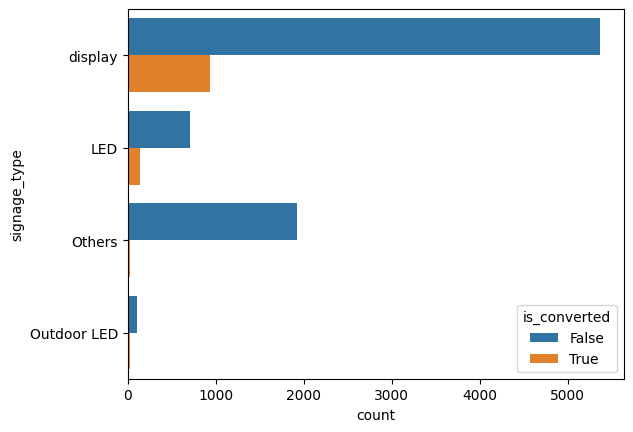

In [26]:
sns.countplot(df_2, y='signage_type', hue='is_converted')

In [31]:
df_2.groupby('signage_type')['is_converted'].value_counts(normalize=True)

signage_type  is_converted
LED           False           0.829988
              True            0.170012
Others        False           0.989733
              True            0.010267
Outdoor LED   False           0.792000
              True            0.208000
display       False           0.851006
              True            0.148994
Name: is_converted, dtype: float64